### 1. Instalação dos Pacotes

In [36]:
%pip install tensorflow pandas matplotlib scikit-learn nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 2. Importação das Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
import nltk
import os

### 3. Carregamento do Dataset

In [3]:
data_path = os.path.join('data', 'train.csv')
df = pd.read_csv(data_path, delimiter=';')

print(f"Dataset carregado: {df.shape}")
print(f"Colunas: {list(df.columns)}")
df.head()

Dataset carregado: (6821, 8)
Colunas: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explicação. Por que as edições feitas sob meu ...,0,0,0,0,0,0
1,000103f0d9cfb60f,Awn! Ele combina com essa cor de fundo na qual...,0,0,0,0,0,0
2,000113f07ec002fd,"Ei, cara, eu realmente não estou tentando come...",0,0,0,0,0,0
3,0001b41b1c6bb37e,“Mais... Eu não consigo fazer sugestões reais ...,0,0,0,0,0,0
4,0001d958c54c6e35,"Você, senhor, é meu herói. Alguma chance de vo...",0,0,0,0,0,0


### 4. Salvando o Dataset Original

In [4]:
df_original = df.copy()

### 5. Pré-processamento de Texto com NLTK

5.1 Download das Stopwords e Definição do Set

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_pt = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to C:\Users\Flavio S.
[nltk_data]     V\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


5.2 Definição da Função de Pré-processamento

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_pt]
    return ' '.join(tokens)

### 6. Comparação Antes/Depois do Pré-processamento

In [7]:
print("Antes:", df_original['comment_text'].iloc[0])
print("Depois:", preprocess_text(df_original['comment_text'].iloc[0]))

Antes: Explicação. Por que as edições feitas sob meu nome de usuário Hardcore Metallica Fan foram revertidas? Elas não eram vandalismos, apenas encerramento de alguns GAs depois que eu votei no FAC do New York Dolls. E, por favor, não remova o template da página de discussão, já que estou aposentado agora. — 89.205.38.27
Depois: explicação edições feitas sob nome usuário hardcore metallica fan revertidas vandalismos apenas encerramento alguns gas votei fac new york dolls favor remova template página discussão aposentado agora 892053827


### 7. Preparação para Classificação Multi-label

In [8]:
from tensorflow.keras.layers import TextVectorization

### 8. Vetorização dos Textos

8.1 Definição de Features e Targets

In [9]:
X = df['comment_text']
y = df[df.columns[2:]].values


8.2 Criação do TextVectorization

In [10]:
MAX_FEATURES = 20000  
vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=1800,
    output_mode='int'
)

8.3 Adaptação e Vetorização

In [11]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

8.4 Checagem dos Formatos

In [12]:
print(f"Formato dos textos vetorizados: {vectorized_text.shape}")
print(f"Formato das labels (multi-label): {y.shape}")

Formato dos textos vetorizados: (6821, 1800)
Formato das labels (multi-label): (6821, 6)


### 9. Análise da Distribuição das Classes

In [13]:
print(f"Distribuição por tipo de toxicidade:")
for i, col in enumerate(df.columns[2:]):
    print(f"   {col}: {y[:, i].sum()} comentários ({y[:, i].mean()*100:.1f}%)")

Distribuição por tipo de toxicidade:
   toxic: 2130 comentários (31.2%)
   severe_toxic: 234 comentários (3.4%)
   obscene: 1180 comentários (17.3%)
   threat: 75 comentários (1.1%)
   insult: 1125 comentários (16.5%)
   identity_hate: 195 comentários (2.9%)


### 10. Criação do Dataset TensorFlow

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(10000)
dataset = dataset.batch(16)    
dataset = dataset.prefetch(8)

### 11. Divisão em Treino, Validação e Teste

In [15]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

11.1 Checagem da Divisão

In [16]:
print(f"Divisão dos dados mantida:")
print(f"Treino: 70% (~{int(len(dataset)*.7)} batches)")
print(f"Validação: 20% (~{int(len(dataset)*.2)} batches)")
print(f"Teste: 10% (~{int(len(dataset)*.1)} batches)")
print("Dados preparados para classificação multi-label!")

Divisão dos dados mantida:
Treino: 70% (~298 batches)
Validação: 20% (~85 batches)
Teste: 10% (~42 batches)
Dados preparados para classificação multi-label!


### 12. Definição e Treinamento do Modelo

12.1 Definição do Modelo

In [17]:
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

12.2 Compilação do Modelo

In [18]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

12.3 Treinamento do Modelo

In [19]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 153s 498ms/step - loss: 0.3447 - val_loss: 0.1817
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 147s 493ms/step - loss: 0.1650 - val_loss: 0.1337
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 148s 496ms/step - loss: 0.1357 - val_loss: 0.1209
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 145s 485ms/step - loss: 0.1210 - val_loss: 0.1270
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 146s 490ms/step - loss: 0.1060 - val_loss: 0.1032
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 147s 492ms/step - loss: 0.1025 - val_loss: 0.0935
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 144s 484ms/step - loss: 0.0909 - val_loss: 0.0939
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 145s 487ms/step - loss: 0.0895 - val_loss: 0.0993
Epoch 9/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 148s 496ms/step - loss: 0.0831 - val_loss: 0.0701
Epoch 10/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 145s 488ms/step - loss: 0.0780 - val_loss: 0.0705


### 13. Visualização do Treinamento

<Figure size 800x500 with 0 Axes>

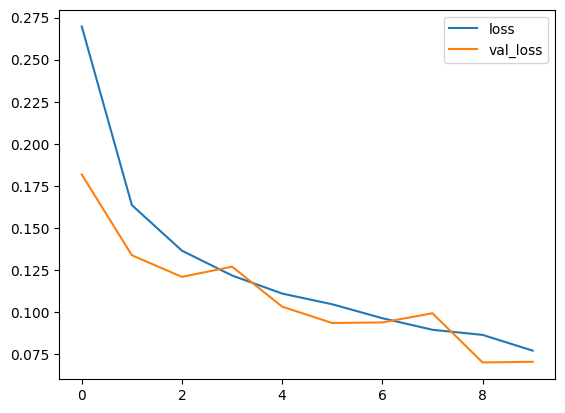

In [20]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### 14. Testes e Avaliação

14.1 Teste de Predição Individual

In [21]:
input_text = vectorizer('Você não prestas mesmo! Eu vou bater-te em você.')
input_text = tf.expand_dims(input_text, 0)
res = model.predict(input_text)
(res > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


array([[0, 0, 0, 0, 0, 0]])

14.2 Teste de Predição em Batch

In [22]:
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)
res.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


(1, 6)

14.3 Avaliação com Métricas

In [23]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
for batch in test.as_numpy_iterator(): 
    X_true, y_true = batch
    yhat = model.predict(X_true)
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### 15. Interface Gradio para Testes Interativos

15.1 Instalação dos Pacotes gradio jinja2

In [24]:
%pip install gradio jinja2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


15.2 Salvando e Recarregando o Modelo

In [25]:
model.save('Shield_AI.keras')
model = tf.keras.models.load_model('Shield_AI.keras')

15.3 Teste Manual de Predição

In [26]:
input_str = vectorizer('Ei, eu te odeio muito!')
res = model.predict(np.expand_dims(input_str, 0))
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


array([[0.97193325, 0.0054306 , 0.4827392 , 0.00926447, 0.36081043,
        0.03307113]], dtype=float32)

15.4 Definição da Função

In [27]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

15.5 Criação e Lançamento da Interface

In [35]:
import gradio as gr

# Dê nomes em português para as classes, se quiser
labels_pt = [
    "Tóxico",
    "Extremamente Tóxico",
    "Obsceno",
    "Ameaça",
    "Insulto",
    "Ódio Identitário"
]

def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    text = ''
    for idx, col in enumerate(labels_pt):
        text += '{}: {}\n'.format(col, 'Sim' if results[0][idx]>0.5 else 'Não')
    return text

interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(
        lines=2,
        label='Comentário',
        placeholder='Digite um comentário para analisar'
    ),
    outputs=gr.Textbox(label='Resultado'),
    title="Shield AI",
    description="Adicione um comentário para analisar se contém elementos como: toxicidade, extrema toxicidade, obscenidade, ameaça, insulto ou ódio identitário.",
    submit_btn="Enviar",
    clear_btn="Limpar"
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7866
* Running on public URL: https://c8916b4f397c9c8752.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
